In [1]:
# Import libraries
from pydataset import data
import pandas as pd
import numpy as np
import math

In [2]:
# Notebook options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

A Random Forest algorithm (RF) can be used for regression and classification problems and is an ensemble machine learning method. An ensemble method is a way to aggregate less predictive base models to produce a better predictive model. The less predictive base models in the case of RF are decision trees, which tend to overfit.

Bagging stands for bootstrap aggregation which is averaging slightly different versions of a model to improve the prediction. It is designed to improve accuracy by reducing the variance which helps to avoid overfitting. Bagging is a special case of the model averaging approach.

Bagging can be performed by either subsetting on rows or on features. selecting a random number of samples from the original set can be performed with replacement. In feature bagging the original feature set is randomly sampled and passed onto different trees without replacement since having redundant features makes no sense.

Whereas I created a decision tree classifier in the previous notebook, I will create a Random Forest for regression problems in this notebook. The underlying decision trees are just slightly different. I will create a decision tree class first, so that we can easily use it for the RF later. Note that the function is again recursive.

Decision trees train by splitting the data into two halves recursively based on certain conditions. If a test set has 10 columns with 10 data points (values) in each column, a total of 10x10 = 100 splits are possible, our task in hand is to find which of these splits is the best for our data. <br>
We use the weighted average (score) of the standard deviation of the two halves as the function to measure the quality of a split, which is equal to the mean squared error (MSE).

The formula used for standard deviation in this decision tree function is different to the one in which each value is subtracted from the mean and than squared. This is because with this formula, it is possible to loop over the values and accumulate the result, making it way more efficient than to calculate the mean in each iteration. Lower score facilitates lower variance, lower variance facilitates grouping of similar data, which will lead to better predictions.
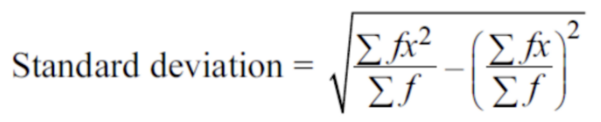

In [4]:
def std_agg(cnt, s1, s2): 
    # The weighted average of standard deviation of the two halves with number of rows in each half as their weights. 
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [5]:
class DecisionTree():
    # As we will now need to split the dataset on rows and on features (by sampling), these parameters become very important.
    # We include parameters for max depth and minimal number of samples in a leaf as well,
    # more shallow trees results in less overfitting, thereby boosting performance when bagged correctly.
    def __init__(self, x, y, n_features, f_idxs, idxs, depth=10, min_leaf=5):
        self.x, self.y = x, y
        self.idxs, self.f_idxs = idxs, f_idxs
        self.min_leaf = min_leaf
        self.depth = depth
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs]) # Each leaf's prediction is the average of the observations in that leaf
        self.score = float('inf') # Starting point, meaning each split will be better than no split at all
        self.find_varsplit()
        
    def find_varsplit(self):
        # Loops through every predictor passed in and finds the best split among all
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: 
            print("We reached a leaf")
            return # If the node is a leaf already, we should not try to devide further    
        # Segregates the column based on its split, lhs is the left side of split, rhs the right side
        x = self.split_col # returns the winning column and the values based on the indexes
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        # Reshuffle and resample features for both sides of the tree after the split
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        # Recursively keep fitting a new tree at the root of both sides of the split until is_leaf is not passed anymore
        # Subtract 1 from the depth to keep track of how deep the tree is so that is_leaf also maxes at the depth level
        print("Starting a new branch on the left side")
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        print("Starting a new branch on the right side")
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)
        
    def find_better_split(self, var_idx):
        # Finds the best split for a specific column
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs] 
        sort_idx = np.argsort(x) # Returns indexes of the column sorted by its values
        sort_y, sort_x = y[sort_idx], x[sort_idx] # Sorts the x and y value based on the sorted indexes
        
        # The number of rows, the sum of the target var and the sum of the target squared (for the right side of sorted split)
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0. # Initiate values for the left side of sorted split
        
        for i in range(0, self.n-self.min_leaf-1): 
            # Loop over the possible splits starting left in the sorted list, 
            # ending at the minimal number of samples from the right side trying every possible split
            # while keeping in mind the minimum number of samples in a split.
            # Since we initiate values at 0 and accumulate in each loop it is not possible to start left on min_leaf
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            # If on the left side there is not yet enough samples to reach min_leaf or if the next value is the same,
            # and so the split would be the same, than continue accumulating
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            
            # Calculate the score at each split
            # If a new best score is obtained, save the var indx, score and specified split to self
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            
            if curr_score < self.score: 
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
                print("Current split updated on variable {} and split {} with score {}".format(self.var_idx, self.split, self.score))
        
        
    # Properties for nested functions make the code concise with the rest of the syntax used in the Class object
    @property
    def split_name(self): 
        # Return the column name rather than the index of the splitcol
        return self.x.columns[self.var_idx] 
        
    @property
    def split_col(self):
        # Splits the idxs based on the splitcol and splitvalue
        return self.x.values[self.idxs, self.var_idx] 
        
    @property
    def is_leaf(self):
        # Function to check if the node is a leaf, i.e. max depth is reached 
        # If the decision tree is recurrently called, the score will be reset to 'inf', if no new split can be made 
        # than 'inf' must stop the call of a new branche in the decision tree
        return self.score == float('inf') or self.depth <= 0 

    
    def predict(self, x):
        # Performs prediction for each row, returning a vector of preds
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        # Goed through the tree from top to bottom until a leaf is reached,
        # follows the splits according to input data and teturns the average of the leaf
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

I will try out the decision tree to see how exactly the function works before implementing the Random Forest.

In [6]:
# Use a very small but clear dataset
df = data('mtcars')
df = df.reset_index(drop=True)
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [8]:
# Preview of the data at hand
df.shape
df.head()

(32, 11)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [9]:
# Seperate the predictors and target variable
X = df.iloc[:,1:]
Y = np.array(df.mpg)

In [10]:
# As we created the Decision tree for the random forest, we're supposed to give indexes for rows and features
idxs = np.random.permutation(len(Y))[:25]
f_idxs = np.random.permutation(X.shape[1])[:10]

In [11]:
# Now we can fit the Decision Tree
# Due to the print statements we can follow its inner workings
DT = DecisionTree(x = X, y = Y, n_features=8, f_idxs=f_idxs, idxs=idxs, depth=3, min_leaf=2)

Current split updated on variable 9 and split 1.0 with score 130.78321500193414
Current split updated on variable 9 and split 2.0 with score 104.77541590148145
Current split updated on variable 4 and split 2.2 with score 85.26678125819004
Starting a new branch on the left side
We reached a leaf
Starting a new branch on the right side
Current split updated on variable 5 and split 15.41 with score 71.09030379645372
Current split updated on variable 5 and split 17.98 with score 66.55512991830639
Current split updated on variable 5 and split 18.0 with score 61.80563409095271
Current split updated on variable 2 and split 97.0 with score 61.62434463562479
Current split updated on variable 2 and split 109.0 with score 61.19029109775741
Current split updated on variable 2 and split 110.0 with score 52.03370787120123
Current split updated on variable 2 and split 123.0 with score 51.4893137934705
Current split updated on variable 2 and split 175.0 with score 49.07025875739076
Starting a new bran

In [12]:
print("The initial best split is on variable {} which is {}, with split value {}.".format(DT.var_idx, DT.split_name, DT.split))

The initial best split is on variable 4 which is wt, with split value 2.2.


In [13]:
# After the initial split we create two new decision trees
DT.lhs
DT.rhs

In [16]:
# Due to the small dataset the left side of the tree was immediately a leaf
print("The best split for all data on the right side of the initial split is on variable {} which is {}, with split value {}."
     .format(DT.rhs.var_idx, DT.rhs.split_name, DT.rhs.split))

The best split for all data on the right side of the initial split is on variable 2 which is hp, with split value 175.0.


Due to the recursive functions, we first continue on the left side of the tree working its way down, until a leaf is reached and we can go back up one step. The tree thereby builts itself from left to right basically, although starting at the top and working its way down. <br>
The next branched can be reached with e.g. DT.lhs.rhs... or DT.lhs.lhs... However due to the random splits of rows and features, the tree could look different every time. This is exactly the idea of the random forest.

The predict function is also a recursive function. It checks at each split, starting at the root, whether the node is a leaf. If so, it returns the average of the train samples in that leaf. If not it compares the input observation with the split in that node, and follows the tree accordingly until a leaf is reached.

In [17]:
# Since we fitted the model on a large part of this data, it is not weird that the predictions are close to the actuals already
DT.predict(np.array(X))

array([21.68571429, 21.68571429, 21.68571429, 17.9       , 17.9       ,
       17.9       , 11.83333333, 21.68571429, 21.68571429, 17.9       ,
       17.9       , 15.5       , 15.5       , 15.5       , 11.83333333,
       11.83333333, 11.83333333, 30.125     , 30.125     , 30.125     ,
       21.68571429, 17.9       , 17.9       , 15.5       , 17.9       ,
       30.125     , 30.125     , 30.125     , 15.5       , 21.68571429,
       15.5       , 21.68571429])

In [18]:
# Do a check with sklearn to see if we are on the right track
# Due to our random permutation the results might be different, but by the looks of it they are quite similar
from sklearn.tree import DecisionTreeRegressor
skl_DT = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)
skl_DT.fit(np.array(X)[idxs], np.array(Y)[idxs])
skl_DT.predict(np.array(X))

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

array([20.225     , 20.225     , 23.6       , 17.02857143, 20.225     ,
       17.02857143, 14.7       , 23.6       , 23.6       , 17.02857143,
       17.02857143, 17.02857143, 17.02857143, 17.02857143, 10.4       ,
       10.4       , 14.7       , 31.4       , 31.4       , 31.4       ,
       21.45      , 20.225     , 17.02857143, 14.7       , 20.225     ,
       28.85      , 23.6       , 28.85      , 14.7       , 20.225     ,
       14.7       , 21.45      ])

Now that the decision tree regressor is in place, it is rather easy to fit a random forest.

In [19]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, random_seed=0, depth=10, min_leaf=5):
        np.random.seed(random_seed) # set seed to be able to reproduce results
        self.x, self.y = x, y 
        self.n_features, self.sample_sz, self.depth, self.min_leaf = n_features, sample_sz, depth, min_leaf
        # All we do is create a bunch of decision trees and store them in an array
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # For every Decision tree a different random set of rows and features is used
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], 
                            self.y[idxs], 
                            self.n_features, 
                            f_idxs,
                            idxs = np.array(range(self.sample_sz)), 
                            depth = self.depth, 
                            min_leaf = self.min_leaf)
        
    def predict(self, x):
        # Once we have all the slightly different decision trees, we call the predict method on each and average the results
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [20]:
# Lets make the decision tree again without the print statements, as we are now going to call it many times
class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs, depth=10, min_leaf=5):
        self.x, self.y = x, y
        self.idxs, self.f_idxs = idxs, f_idxs
        self.min_leaf = min_leaf
        self.depth = depth
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs]) 
        self.score = float('inf') 
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return 
        x = self.split_col   
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)
        
    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs] 
        sort_idx = np.argsort(x) 
        sort_y, sort_x = y[sort_idx], x[sort_idx] 
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0. 
        
        for i in range(0, self.n-self.min_leaf-1): 
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score < self.score: 
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
        
    @property
    def split_name(self): 
        return self.x.columns[self.var_idx] 
        
    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx] 
        
    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0 

    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

In [21]:
# Initiate our variables again in order to fit the Random Forest
X = df.iloc[:,1:]
Y = np.array(df.mpg)
n_trees = 10
n_features = 8
sample_sz = 24
min_leaf = 2

In [22]:
# And actually fit the model to the 'traindata'
RF = RandomForest(x = X, y = Y, n_trees=n_trees, n_features=n_features, sample_sz=sample_sz, min_leaf=min_leaf)

In [23]:
# Using the predict method as we did with the Decision Tree
RF.predict(np.array(X))

array([21.13333333, 21.13333333, 22.49683333, 20.014     , 17.6915    ,
       19.5065    , 14.346     , 22.04016667, 22.49683333, 18.76316667,
       18.76316667, 16.27283333, 16.27283333, 16.27283333, 12.944     ,
       12.944     , 12.944     , 30.13933333, 30.87733333, 30.87733333,
       22.09016667, 17.2195    , 17.2915    , 13.79933333, 17.6915    ,
       30.01066667, 28.436     , 30.01066667, 15.27266667, 20.18466667,
       14.996     , 21.9235    ])

In [24]:
# We can find that the Random Forest object now indeed holds 10 decision trees
RF.trees

In [25]:
# So we can actually use each individual Decision Tree to make predictions or check how it is build up
pred_list = []
for tree in RF.trees:
    pred_list.append(tree.predict(np.array(X))[0])

In [26]:
# The first observation received a prediction of 21.1333..
# Which is made up out of the 10 predictions from all the trees
pred_list

[20.7,
 21.3,
 22.22,
 21.54,
 20.14,
 20.566666666666666,
 21.3,
 22.3,
 20.7,
 20.566666666666666]

In [27]:
# As we see this indeed lines up with the average prediction that the Random Forest gave us
np.mean(pred_list)

21.133333333333333

In [3]:
# Used resources
#https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249
#https://www.analyticsvidhya.com/blog/2018/12/building-a-random-forest-from-scratch-understanding-real-world-data-products-ml-for-programmers-part-3/
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#https://towardsdatascience.com/de-coding-random-forests-82d4dcbb91a1